# News Headline Sarcasm Detection

### Authors: Aditya Iyer, Minxi Lin, David Setrakyan, Zimeng Yang
### Course: PSTAT 134
### Date: 16 March 2025

## Introduction

### Overview 

Detecting sarcasm in text is a challenging yet important task in natural language processing (NLP), particularly for improving sentiment analysis and chatbot interactions. 

This project focuses on sarcasm detection in news headlines using machine learning techniques. The [dataset](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data), "News Headlines Dataset for Sarcasm Detection" by Risabh Mishra, sourced from Kaggle, contains headlines from **The Onion** (sarcastic) and **HuffPost** (non-sarcastic), providing a balanced corpus of formal news text. 

Our objective is to develop an NLP model capable of distinguishing sarcastic headlines from non-sarcastic ones by leveraging **exploratory data analysis, feature engineering, and various classification models**. Through tokenization, stopword removal, and word embeddings, we extract meaningful linguistic patterns that differentiate sarcasm from literal statements. 

Our final model, a bi-directional LSTM using pre-trained GloVe embeddings, effectively detects sarcasm with high accuracy. The results of our study offer insights into how sarcasm manifests in news language and demonstrate the effectiveness of machine learning models in identifying nuanced expressions of irony.

## Methods

### Loading and Cleaning the Dataset

#### Packages Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import string
import missingno as msno
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import bigrams

In [2]:
import json

def parse_data(file):
    for l in open(file, 'r'):
        yield json.loads(l)

data = list(parse_data('data/Sarcasm_Headlines_Dataset_v2.json'))
data = pd.DataFrame(data)
df = data

#### Data Information

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None


There are a total of 28619 rows and 3 columns in the dataset. is_sarcastic is a binary variable consisting of 0 and 1. headline and article_link are strings.

In [4]:
data.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


The dataset is loaded from a json file using `parse_data()`, and then stored in a pandas dataframe. The dataset has 3 columns:

- `is_sarcastic`: Binary target variable (1 for sarcastic, 0 for non-sarcastic)
- `headline`: The actual news headline text
- `article_link`: The source link for the article

### Missing and Duplicate Data

       is_sarcastic                                           headline  \
646               0                        hillary clinton vs. herself   
14897             1  nation not sure how many ex-trump staffers it ...   
18572             0                        hillary clinton vs. herself   
25743             1  nation not sure how many ex-trump staffers it ...   

                                            article_link  
646    https://www.huffingtonpost.comhttp://nymag.com...  
14897  https://politics.theonion.com/nation-not-sure-...  
18572  https://www.huffingtonpost.comhttp://nymag.com...  
25743  https://politics.theonion.com/nation-not-sure-...  


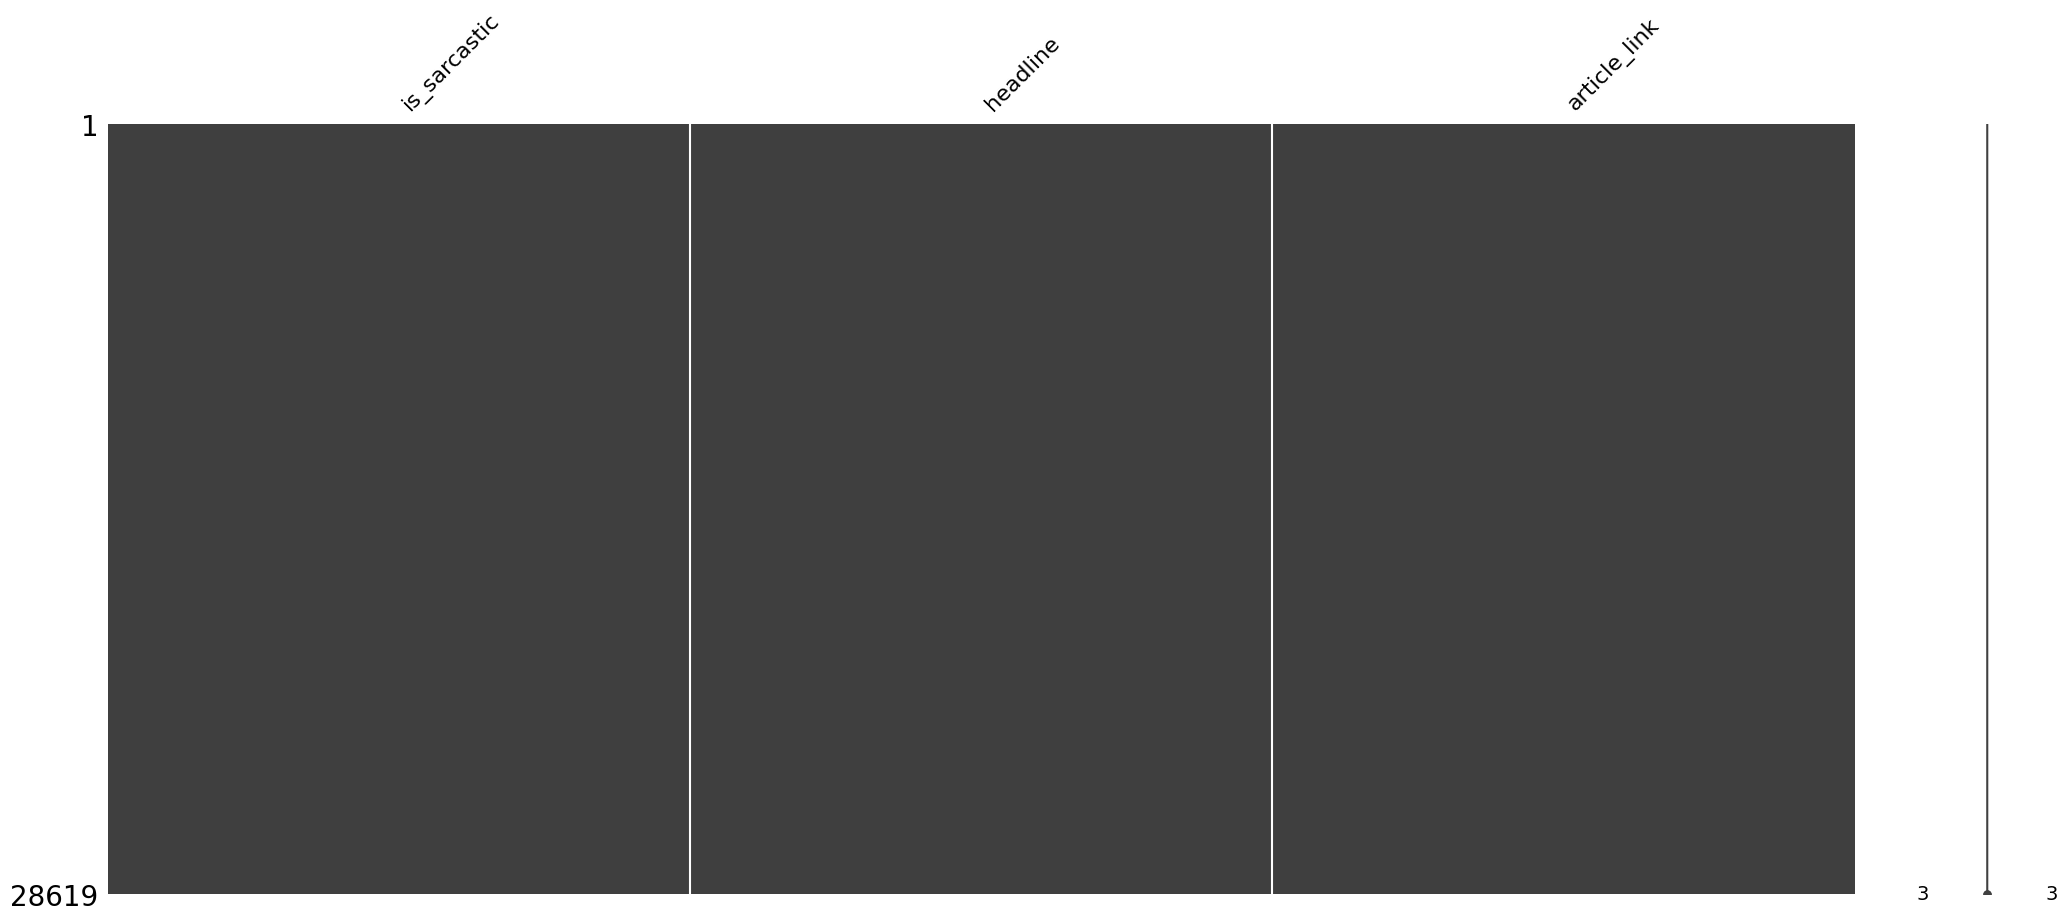

In [5]:
msno.matrix(data)

print(df[df.duplicated(keep = False)])
df = df[df.duplicated(keep='first') == False]

The dataset had no missing data, as well as two duplicated rows, so we removed them from the dataset as well.

### EDA

#### Sarcastic vs Non-Sarcastic Headline Distributions

![Sarcastic vs Non-Sarcastic Headline Distributions](/Users/aditya/Documents/ucsb/pstat-134/sarcasm-detection/images/headline_distr.png)

The two classes are almost balanced, with the number of non-sarcastic headlines being slightly higher. The "Not sarcastic" class has approximately 15,000 values and "sarcastic" class has approximately 13,500 values.

#### Most Commonly Occurring Bigrams for both Headline Types

![bigrams](/Users/aditya/Documents/ucsb/pstat-134/sarcasm-detection/images/common_words.png)


The five most commonly-occurring bigrams for sarcastic headlines are *area man*, *white house*, *study finds*, *introduces new*, and *unveils new*. The five most commonly-occurring bigrams for non-sarcastic headlines are *donald trump*, *hilary clinton*, *donald trumps*, *new york*, and *white house*. The frequencies of area man and donald trump significantly outnumber the other bigrams separately in sarcastic and not sarcastic classes. It seems that the full names of celebrities, particularly political figures in many of these cases, are more likely to occur in non-sarcastic headlines.

#### Sentiment Analysis

#### Most Commonly Occurring words by sentiment

![word_cloud_image](/Users/aditya/Documents/ucsb/pstat-134/sarcasm-detection/images/word_cloud_full.png)

Words with positive sentiments are more common than these with negative sentiments. The most commonly-occurring words with 'positive' sentiment are 'like', 'good', and 'best', and the most common words with negative sentiment are 'death', 'dead', 'war' and 'stop'.

### Data Preprocessing & Feature Engineering

Before training our sarcasm detection models, we **preprocessed the dataset** to ensure it was in a structured numerical format suitable for machine learning and deep learning models.

1. **Text Cleaning & Tokenization**:  
   - We removed punctuation and special characters.  
   - Headlines were converted to lowercase and tokenized into individual words.  
   - Stopwords (e.g., "the", "is", "and") were removed to improve efficiency.

2. **Numerical Representation of Text**:  
   - We created a **vocabulary dictionary**, assigning a unique index to each word.  
   - Headlines were then **converted into sequences of word indices**.  
   - Headlines were **padded to a fixed length (25 words)** to standardize input size.

3. **Using Pre-Trained Word Embeddings (GloVe)**:  
   - Instead of training embeddings from scratch, we used **pre-trained GloVe embeddings (100D)**.  
   - We mapped our vocabulary to **GloVe vectors**, ensuring our model leveraged high-quality word representations.  


#### Re-reading in the data for modeling

In [ ]:
import re
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

data.columns = ['Sarcastic', 'Headline', 'Link']

# 1. Clean text, remove punctuation, and stopwords
stop_words_removed = []
for i in data['Headline']:
    i = re.sub(r"[^a-zA-Z\s]", "", i)  # Remove special characters
    main_words = ' '.join([j for j in i.split() if j.lower() not in ENGLISH_STOP_WORDS])
    stop_words_removed.append(main_words)

# 2. Tokenization
tokenized_corpus = [word_tokenize(i) for i in stop_words_removed]
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_idx = {word: i for i, word in enumerate(vocab)}

# 3. Convert words to numerical indices
tokenized_corpus_num = [[word_to_idx[word] for word in headline] for headline in tokenized_corpus]

# 4. Padding sequences to 25 words
tensor_corpus = [torch.tensor(seq, dtype=torch.long) for seq in tokenized_corpus_num]
padded_sequences = pad_sequence(tensor_corpus, batch_first=True, padding_value=len(vocab))
padded_sequences = padded_sequences[:, :25]  # Truncate to max_length = 25

# 5. Prepare labels
sarcasm = torch.tensor(data['Sarcastic'].values, dtype=torch.long)

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, sarcasm, test_size=0.2, stratify=sarcasm, shuffle=True)

# 7. Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.twitter.27B.100d.txt', encoding="utf-8") as GloVe:
    for entry in GloVe:
        values = entry.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

# 8. Create embedding matrix
embedding_matrix = np.zeros((len(word_to_idx) + 1, embedding_dim))
for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model Selection Performance Comparison

We experimented with multiple models before selecting the **GloVe LSTM** as our final model. Below is a comparison of each model's performance, along with key observations.

| Model | Accuracy | Explanation |
|-------|----------|----------------------------------------------|
| **CBOW Embeddings Model** | 51.2% | Performed poorly due to **lack of continuous data**—headline texts are independent, unlike books or long documents where CBOW typically excels. |
| **Skip-Gram Word2Vec** | 56.8% | Outperformed CBOW but still struggled due to **limited training data**. Performed worse than Logistic Regression. |
| **Logistic Regression (TF-IDF + Features)** | 79.9% | Used **headline length, punctuation features (exclamation/question marks), and TF-IDF unigram features**, but additional predictors had **negligible impact**. Hyperparameter tuning showed the default model was already optimal. |
| **GloVe LSTM Model (Final)** | **98.6%** | Used **pre-trained Twitter GloVe embeddings** with an **LSTM classifier**, significantly outperforming other models due to its ability to capture **contextual relationships in sarcasm**. |


### Final Model: GloVe LSTM for Sarcasm Detection

## Final Model: GloVe LSTM for Sarcasm Detection

Our final model is a **bi-directional LSTM** using **pre-trained GloVe embeddings**, which achieved the highest accuracy (98.6%) in sarcasm classification.  

### Why We Chose This Model:
- **Captures contextual meaning** in text better than traditional models.
- **Uses pre-trained word embeddings (GloVe)** instead of training from scratch.
- **Bi-directional LSTM** tracks long-term dependencies, making it ideal for sarcastic sentence structures.

### Model Architecture:
1. **Embedding Layer**: Uses pre-trained GloVe word embeddings.
2. **Bi-Directional LSTM**: Processes text in both forward and backward directions.
3. **Fully Connected Layer**: Produces a probability output for sarcasm detection.
4. **Sigmoid Activation**: Converts the model's output into a binary classification (sarcastic vs. non-sarcastic).


The implementation can be seen below:

In [7]:
import torch
import torch.nn as nn
from torch.nn import Embedding
from torch.utils.data import Dataset, DataLoader

class SarcasmLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=64, dropout=0.2, rdropout=0.25):
        super().__init__()

        # Load pre-trained GloVe embeddings (frozen)
        self.embedding_layer = Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32), 
            freeze=True, 
            padding_idx=len(vocab)
        )

        # Bi-directional LSTM
        self.lstm = nn.LSTM(
            input_size=100, 
            hidden_size=hidden_dim,
            batch_first=True, 
            dropout=rdropout,
            bidirectional=True
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2, 1)

        # Sigmoid activation function for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last hidden state
        x = self.fc(x)
        return self.sigmoid(x)

### Model Training & Optimization

We trained our **GloVe LSTM model** using **Binary Cross-Entropy Loss (BCELoss)** for binary classification and optimized it with the **Adam optimizer (learning rate = 0.001)**. The dataset was **converted into PyTorch tensors** and split into **80% training and 20% testing** sets. Training was conducted over **30 epochs** using **mini-batches (batch size = 32)** to improve stability and efficiency. Accuracy was tracked at each epoch to monitor performance. After optimizing the model's weights through **backpropagation**, we saved the final trained model for evaluation.

In [ ]:
# Dataset class for PyTorch
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare data loaders
train_dataset = SarcasmDataset(X_train, y_train)
test_dataset = SarcasmDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cpu")
model2 = SarcasmLSTM(embedding_matrix=embedding_matrix).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model2.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track performance
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    # Compute loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the trained model
torch.save(model2.state_dict(), "sarcasm_lstm_GloVe2.pth")
print("Model Saved!")

### Results

### Model Performance

After **30 epochs of training**, our model achieved **98.6% accuracy**, significantly outperforming all other models tested.

| Metric | Value |
|--------|-------|
| **Final Accuracy** | 98.6% |
| **Final Testing Loss** | 0.22 |
| **Best Alternative Model (Logistic Regression)** | 79.9% |

### Key Takeaways:
- **The LSTM model successfully captured long-term dependencies** in sarcastic text.
- **Using pre-trained GloVe embeddings significantly improved performance** compared to CBOW/Skip-Gram.
- **Unlike logistic regression**, which relied on manual feature engineering, LSTMs learn **contextual meaning from raw text**.

The below visualization shows how the GloVe model's test loss changed over time, with the x-axis representing epochs and the y-axis representing test loss, how the model is performing on unseen data.


![Test Loss Graph for GloVe LSTM Model](/Users/aditya/Documents/ucsb/pstat-134/sarcasm-detection/images/test_loss.png)


The model starts with a higher test loss, around ~0.45, and reaches a low point around epoch 15. After that, from epochs 15 to 30, the test loss oscillates, but we tested this for overfitting - the model here is simply adjusting weights and fine-tuning them, rather than overfitting as the test loss doesn't seem to increase.

### Performance Evaluation
Our final model selection was driven by accuracy and ability to capture contextual sarcasm. 
While traditional models like **Logistic Regression** performed reasonably well (79.9%), neural network approaches showed the most promise. 
Both **CBOW (51.2%)** and **Skip-Gram (56.8%)** struggled due to the dataset’s independent headline structure. 
By leveraging **pre-trained GloVe embeddings**, our **GloVe LSTM model reached 98.6% accuracy**, demonstrating its superior capability in sarcasm detection.


We modified the training of the model by testing it on both V1 and V2 of the dataset (Both contain their own unique data). V2 was the standard used for this project (With more recent headlines), and V1 was the original. When trained on V1 **and** V2, the model then had a testing accuracy of 95.3% on the overall training set compared to the 98.6% accuracy of the model trained only on V2. This could represent some bias in the way it trained, but we expect this. Since the time range for both datasets are different, key differentiators in the V2 dataset (non-sarcastic articles talking about Trump, Hillary, etc) might not have applied as much to V1 content. However, the 95.3% accuracy is still extremely high.

Additionally, the accuracy and error rates were similar for both sarcastic and non sarcastic headlines, showing that the model didn't over or under-report a certain type of headline.

## Conclusion & Future Work

Our study demonstrates that deep learning models leveraging GloVe embeddings are highly effective for sarcasm detection. Our Bi-directional LSTM model achieved 98.6% accuracy, outperforming traditional machine learning approaches. Despite this success, sarcasm detection remains inherently challenging due to its contextual nature. Future work could incorporate Transformer-based models like BERT, which excel in contextual understanding, and multimodal sarcasm detection by combining textual and visual cues from memes or GIFs. Expanding the dataset to include social media sarcasm (e.g., Twitter, Reddit) would further enhance real-world applicability.

## References
- Mishra, R. (2019). *News Headlines Dataset for Sarcasm Detection*. [Kaggle Dataset](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data)
- Pennington, J., Socher, R., & Manning, C. (2014). *GloVe: Global Vectors for Word Representation*. [Paper](https://nlp.stanford.edu/pubs/glove.pdf)
- Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. Neural Computation.
